# Projeto de Previsão da Inflação (IPCA) no Brasil - Modelo Intermediário

Este notebook representa a segunda etapa do projeto de previsão da variação mensal do IPCA. Nesta versão "intermediária", o objetivo é aprimorar o modelo básico de Regressão Linear (que utilizava apenas lags do IPCA) através da inclusão de variáveis macroeconômicas exógenas relevantes: a Taxa Selic e a Taxa de Câmbio (USD/BRL).

**Objetivos Específicos desta Versão:**
* Coletar e tratar os dados históricos do IPCA, da Taxa Selic e da Taxa de Câmbio a partir de 2010.
* Realizar uma análise exploratória das novas séries.
* Integrar as novas variáveis ao conjunto de dados.
* Criar features baseadas em lags para todas as variáveis.
* Treinar um modelo de Regressão Linear com o conjunto de features enriquecido.
* Avaliar o desempenho do novo modelo e compará-lo com a versão básica.

*A motivação é verificar se a adição de informação macroeconômica pode melhorar a capacidade preditiva do modelo simples.*

In [1]:
!pip install python-bcb

In [2]:
import pandas as pd
import numpy as np
from bcb import sgs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Coleta e Preparação dos Dados (a partir de 2010)

Nesta seção, faremos a coleta das séries temporais do IPCA, da Taxa Selic (efetiva diária) e da Taxa de Câmbio (PTAX venda). Todas as séries serão obtidas a partir de janeiro de 2010 para garantir alinhamento e contornar possíveis problemas da API com dados mais antigos. Após a coleta, as séries diárias (Selic e Câmbio) serão agregadas para uma frequência mensal.

In [13]:
# Coleta do IPCA (Série 433)
ipca_dados = sgs.get({'IPCA': 433}, start='2010-01-01')
ipca_dados.index = pd.to_datetime(ipca_dados.index) # Garante DatetimeIndex

ipca_dados.index = ipca_dados.index + pd.offsets.MonthEnd(0)

print("--- IPCA Dados ---")
print(ipca_dados.head())
print("\n")
print(ipca_dados.tail())
ipca_dados.info()

--- IPCA Dados ---
            IPCA
Date            
2010-01-31  0.75
2010-02-28  0.78
2010-03-31  0.52
2010-04-30  0.57
2010-05-31  0.43


            IPCA
Date            
2024-12-31  0.52
2025-01-31  0.16
2025-02-28  1.31
2025-03-31  0.56
2025-04-30  0.43
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-31 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IPCA    184 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [29]:
# Coleta e Processamento da Selic (Série 11 - Diária Efetiva)
print("\n--- Buscando Taxa Selic Diária Efetiva (código 11) a partir de 2010 ---")
selic_mensal = pd.DataFrame()

try:
    start_date_2010 = pd.to_datetime('2010-01-01')
    end_date_2019 = pd.to_datetime('2019-12-31')
    start_date_2020 = pd.to_datetime('2020-01-01')

    selic_diaria_p1 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2010.strftime('%Y-%m-%d'), end=end_date_2019.strftime('%Y-%m-%d'))
    selic_diaria_p2 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2020.strftime('%Y-%m-%d'))

    selic_diaria_raw = pd.concat([selic_diaria_p1, selic_diaria_p2])
    selic_diaria_raw = selic_diaria_raw[~selic_diaria_raw.index.duplicated(keep='first')]
    selic_diaria_raw.index = pd.to_datetime(selic_diaria_raw.index)

    selic_mensal_temp = selic_diaria_raw.resample('ME').mean() # Média mensal da taxa diária
    selic_mensal_temp.rename(columns={'SELIC_DIARIA_AD': 'SELIC_DIARIA_AVG_MENSAL'}, inplace=True)
    selic_mensal = selic_mensal_temp

    print("\nSelic Diária Média Mensal (% a.d.):")
    print(selic_mensal.head())
    print("\n")
    print(selic_mensal.tail())
    selic_mensal.info()

except Exception as e:
    print(f"Erro ao buscar ou processar Selic Diária Efetiva (11): {e}")


--- Buscando Taxa Selic Diária Efetiva (código 11) a partir de 2010 ---

Selic Diária Média Mensal (% a.d.):
            SELIC_DIARIA_AVG_MENSAL
Date                               
2010-01-31                 0.032925
2010-02-28                 0.032927
2010-03-31                 0.032927
2010-04-30                 0.033191
2010-05-31                 0.035652


            SELIC_DIARIA_AVG_MENSAL
Date                               
2025-01-31                 0.045833
2025-02-28                 0.049037
2025-03-31                 0.050508
2025-04-30                 0.052531
2025-05-31                 0.053832
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185 entries, 2010-01-31 to 2025-05-31
Freq: ME
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SELIC_DIARIA_AVG_MENSAL  185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [30]:
# Coleta e Processamento do Câmbio (Série 1 - Dólar PTAX Venda)
print("\n--- Buscando Taxa de Câmbio (código 1) a partir de 2010 ---")
cambio_mensal = pd.DataFrame()

try:
    start_date_2010 = pd.to_datetime('2010-01-01')
    end_date_2019 = pd.to_datetime('2019-12-31')
    start_date_2020 = pd.to_datetime('2020-01-01')

    cambio_diario_p1 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2010.strftime('%Y-%m-%d'), end=end_date_2019.strftime('%Y-%m-%d'))
    cambio_diario_p2 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2020.strftime('%Y-%m-%d'))

    cambio_diario_raw = pd.concat([cambio_diario_p1, cambio_diario_p2])
    cambio_diario_raw = cambio_diario_raw[~cambio_diario_raw.index.duplicated(keep='first')]
    cambio_diario_raw.index = pd.to_datetime(cambio_diario_raw.index)

    cambio_mensal_temp = cambio_diario_raw.resample('ME').mean() # Média mensal
    cambio_mensal_temp.rename(columns={'CAMBIO_USD_VENDA': 'CAMBIO_USD_AVG'}, inplace=True)
    cambio_mensal = cambio_mensal_temp

    print("\nCâmbio Médio Mensal:")
    print(cambio_mensal.head())
    print("\n")
    print(cambio_mensal.tail())
    cambio_mensal.info()

except Exception as e:
    print(f"Erro ao buscar ou processar Taxa de Câmbio (1): {e}")


--- Buscando Taxa de Câmbio (código 1) a partir de 2010 ---

Câmbio Médio Mensal:
            CAMBIO_USD_AVG
Date                      
2010-01-31        1.779820
2010-02-28        1.841633
2010-03-31        1.785843
2010-04-30        1.756570
2010-05-31        1.813190


            CAMBIO_USD_AVG
Date                      
2025-01-31        6.021773
2025-02-28        5.765645
2025-03-31        5.746811
2025-04-30        5.783675
2025-05-31        5.665069
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185 entries, 2010-01-31 to 2025-05-31
Freq: ME
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CAMBIO_USD_AVG  185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


### Junção dos DataFrames
Unindo as três séries (IPCA, Selic e Câmbio) em um único DataFrame, utilizando a data como chave de junção. A junção interna (`how='inner'`) garante que teremos apenas os meses para os quais todas as três séries possuem dados.

In [16]:
# Unindo os DataFrames
df_intermediario = pd.merge(ipca_dados, selic_mensal, left_index=True, right_index=True, how='inner')
df_intermediario = pd.merge(df_intermediario, cambio_mensal, left_index=True, right_index=True, how='inner')

print("\n--- DataFrame Intermediário Combinado ---")
print(df_intermediario.head())
print("\n")
print(df_intermediario.tail())
df_intermediario.info()


--- DataFrame Intermediário Combinado ---
            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
Date                                                     
2010-01-31  0.75                 0.032925        1.779820
2010-02-28  0.78                 0.032927        1.841633
2010-03-31  0.52                 0.032927        1.785843
2010-04-30  0.57                 0.033191        1.756570
2010-05-31  0.43                 0.035652        1.813190


            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
Date                                                     
2024-12-31  0.52                 0.044158        6.097029
2025-01-31  0.16                 0.045833        6.021773
2025-02-28  1.31                 0.049037        5.765645
2025-03-31  0.56                 0.050508        5.746811
2025-04-30  0.43                 0.052531        5.783675
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-31 to 2025-04-30
Data columns (total 3 columns):
 #   Column         

## 2. Análise Exploratória dos Dados (EDA) - DataFrame Combinado

Vamos visualizar as séries combinadas para entender suas tendências e possíveis correlações.

In [17]:
# Estatísticas Descritivas do DataFrame Combinado
print("\n--- Estatísticas Descritivas (df_intermediario) ---")
print(df_intermediario.describe())


--- Estatísticas Descritivas (df_intermediario) ---
             IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
count  184.000000               184.000000      184.000000
mean     0.480163                 0.036155        3.623307
std      0.361958                 0.012710        1.391992
min     -0.680000                 0.007469        1.563938
25%      0.247500                 0.026759        2.234795
50%      0.450000                 0.039541        3.552568
75%      0.710000                 0.046024        5.036231
max      1.620000                 0.052531        6.097029


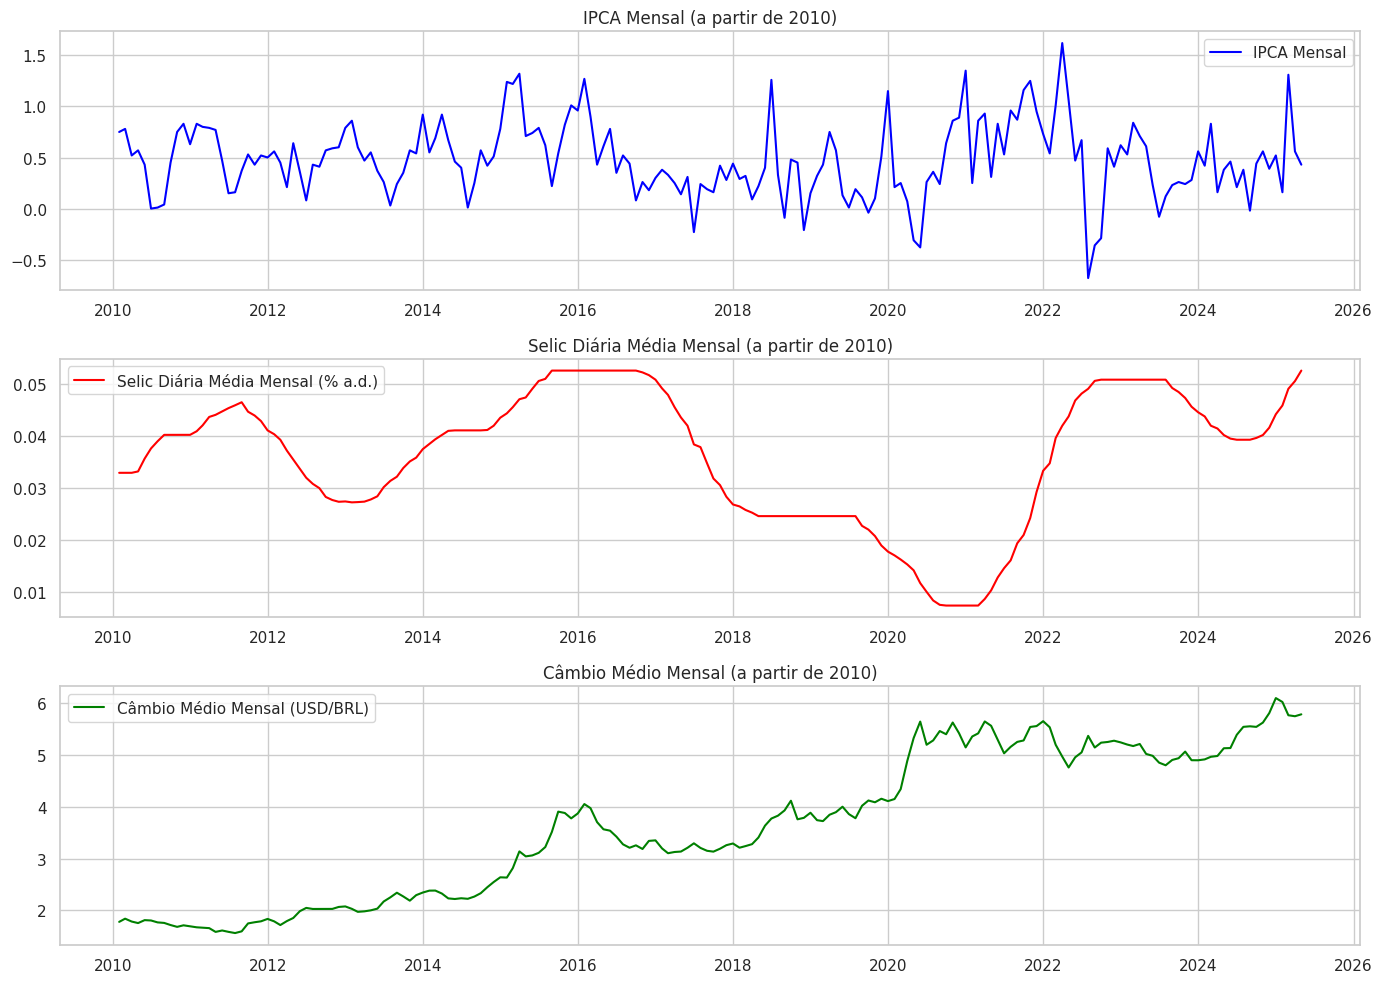

In [19]:
# Gráficos das séries temporais (IPCA, Selic, Câmbio)
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(df_intermediario.index, df_intermediario['IPCA'], label='IPCA Mensal', color='blue')
plt.title('IPCA Mensal (a partir de 2010)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_intermediario.index, df_intermediario['SELIC_DIARIA_AVG_MENSAL'], label='Selic Diária Média Mensal (% a.d.)', color='red')
plt.title('Selic Diária Média Mensal (a partir de 2010)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_intermediario.index, df_intermediario['CAMBIO_USD_AVG'], label='Câmbio Médio Mensal (USD/BRL)', color='green')
plt.title('Câmbio Médio Mensal (a partir de 2010)')
plt.legend()

plt.tight_layout()
plt.show()

### Análise Visual das Séries Temporais (IPCA, Selic, Câmbio - a partir de 2010)

Os gráficos acima exibem a evolução mensal do IPCA, da média da taxa Selic diária (% a.d.) e da média da taxa de Câmbio (USD/BRL) desde janeiro de 2010 até aproximadamente o início de 2025.

*Observações:*

* **IPCA:** A inflação mensal (gráfico superior) neste período apresentou picos notáveis em alguns momentos. Destacam-se:
    * Um período de inflação mais elevada e volátil por volta de **2015-2016**.
    * Um novo surto inflacionário significativo a partir de **2021, atingindo o pico em 2022** e mostrando uma desaceleração posterior.
    * É interessante notar a ocorrência de deflação (valores abaixo de zero) em meados de **2022**.

* **Selic (Média Diária Mensal):** A trajetória da Selic (gráfico do meio) ilustra claramente os ciclos de política monetária:
    * Houve um ciclo de elevação da taxa de juros que se intensificou em **2014-2015**, atingindo um patamar elevado.
    * Seguiu-se um período de queda expressiva da Selic, especialmente entre **2017 e 2020**, chegando a mínimas históricas.
    * A partir do início de **2021**, observa-se uma rápida e acentuada elevação da Selic, coincidindo com o período de alta inflacionária.
    * Mais recentemente, no final do período do gráfico (a partir de meados de 2023), a Selic iniciou uma trajetória de queda.
    * Visualmente, os grandes movimentos da Selic parecem ter uma relação inversa e defasada com os movimentos do IPCA (ex: a alta da Selic em 2021-2022 antecedeu a queda da inflação em 2022-2023).

* **Câmbio (Médio Mensal):** A taxa de Câmbio USD/BRL (gráfico inferior) também passou por diferentes fases:
    * Uma tendência de valorização do dólar (desvalorização do Real) mais acentuada a partir de **2014-2015**.
    * Um novo salto significativo na taxa de câmbio ocorreu em **2020** (início da pandemia), mantendo-se em um patamar mais elevado desde então, com flutuações.
    * Períodos de desvalorização cambial parecem estar associados a pressões inflacionárias subsequentes no IPCA.

* **Relações Visuais Gerais:** As dinâmicas das três séries sugerem interdependência. A política monetária (Selic) reage e tenta influenciar a inflação (IPCA), enquanto o câmbio atua como um fator de pressão ou alívio inflacionário. A inclusão da Selic e do Câmbio como variáveis explicativas no modelo de IPCA parece promissora.



In [20]:
# Criação de Lags
# Lags do IPCA
df_intermediario['IPCA_lag1'] = df_intermediario['IPCA'].shift(1)
df_intermediario['IPCA_lag2'] = df_intermediario['IPCA'].shift(2)
df_intermediario['IPCA_lag3'] = df_intermediario['IPCA'].shift(3)

# Lags da Selic
df_intermediario['SELIC_lag1'] = df_intermediario['SELIC_DIARIA_AVG_MENSAL'].shift(1)
df_intermediario['SELIC_lag2'] = df_intermediario['SELIC_DIARIA_AVG_MENSAL'].shift(2)

# Lags do Câmbio
df_intermediario['CAMBIO_lag1'] = df_intermediario['CAMBIO_USD_AVG'].shift(1)
df_intermediario['CAMBIO_lag2'] = df_intermediario['CAMBIO_USD_AVG'].shift(2)

print("\n--- DataFrame com todos os lags (início) ---")
print(df_intermediario.head(5)) # Mostrar mais linhas para ver os lags surgindo

# Removendo NaNs
df_intermediario.dropna(inplace=True)

print("\n--- DataFrame após remover NaNs (início) ---")
print(df_intermediario.head())
df_intermediario.info()


--- DataFrame com todos os lags (início) ---
            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG  IPCA_lag1  \
Date                                                                   
2010-01-31  0.75                 0.032925        1.779820        NaN   
2010-02-28  0.78                 0.032927        1.841633       0.75   
2010-03-31  0.52                 0.032927        1.785843       0.78   
2010-04-30  0.57                 0.033191        1.756570       0.52   
2010-05-31  0.43                 0.035652        1.813190       0.57   

            IPCA_lag2  IPCA_lag3  SELIC_lag1  SELIC_lag2  CAMBIO_lag1  \
Date                                                                    
2010-01-31        NaN        NaN         NaN         NaN          NaN   
2010-02-28        NaN        NaN    0.032925         NaN     1.779820   
2010-03-31       0.75        NaN    0.032927    0.032925     1.841633   
2010-04-30       0.78       0.75    0.032927    0.032927     1.785843   
2010-05-31 

A criação dos lags introduziu valores `NaN` (ausentes) nas primeiras linhas do `df_intermediario`, pois não há dados suficientes para calcular todos os lags para essas observações iniciais. Como o maior lag utilizado foi de 3 meses (para o IPCA), as 3 primeiras linhas do DataFrame após a criação dos lags continham `NaN`s.

Essas linhas foram removidas com o método `.dropna()`. O `.info()` resultante mostra que o DataFrame agora possui 181 entradas e está pronto para a separação em features e variável alvo.


### Definindo Features (X_int) e Variável Alvo (y_int) para o Modelo Intermediário

Agora, separamos o DataFrame processado em:
* `X_int`: DataFrame contendo todas as nossas features (lags do IPCA, lags da Selic e lags do Câmbio).
* `y_int`: Série contendo a nossa variável alvo (o valor atual do IPCA que queremos prever).

In [21]:
# Definindo Features (X_int) e Variável Alvo (y_int)
features_intermediarias = [
    'IPCA_lag1', 'IPCA_lag2', 'IPCA_lag3',
    'SELIC_lag1', 'SELIC_lag2',
    'CAMBIO_lag1', 'CAMBIO_lag2'
]
X_int = df_intermediario[features_intermediarias]
y_int = df_intermediario['IPCA']

print("\n--- Features X_int (primeiras linhas) ---")
print(X_int.head())
print("\n--- Alvo y_int (primeiras linhas) ---")
print(y_int.head())


--- Features X_int (primeiras linhas) ---
            IPCA_lag1  IPCA_lag2  IPCA_lag3  SELIC_lag1  SELIC_lag2  \
Date                                                                  
2010-04-30       0.52       0.78       0.75    0.032927    0.032927   
2010-05-31       0.57       0.52       0.78    0.033191    0.032927   
2010-06-30       0.43       0.57       0.52    0.035652    0.033191   
2010-07-31       0.00       0.43       0.57    0.037600    0.035652   
2010-08-31       0.01       0.00       0.43    0.038978    0.037600   

            CAMBIO_lag1  CAMBIO_lag2  
Date                                  
2010-04-30     1.785843     1.841633  
2010-05-31     1.756570     1.785843  
2010-06-30     1.813190     1.756570  
2010-07-31     1.806529     1.813190  
2010-08-31     1.769636     1.806529  

--- Alvo y_int (primeiras linhas) ---
Date
2010-04-30    0.57
2010-05-31    0.43
2010-06-30    0.00
2010-07-31    0.01
2010-08-31    0.04
Name: IPCA, dtype: float64


As features (`X_int`) e a variável alvo (`y_int`) foram definidas. Cada linha em `X_int` contém os valores defasados do IPCA, Selic e Câmbio que serão usados para tentar prever o valor do IPCA correspondente na mesma linha de `y_int`.

## Treinamento do Modelo (Regressão Linear com Novas Features)

Com o novo conjunto de features (`X_int`) e a variável alvo (`y_int`) definidos, procederemos com a divisão dos dados em treino e teste e o treinamento do modelo de Regressão Linear.

### Divisão em Dados de Treino e Teste
Manteremos a estratégia de usar os últimos **24 meses** para teste, para permitir uma comparação mais direta com o desempenho do modelo básico.

In [22]:
#  Divisão em Dados de Treino e Teste
n_teste_int = 24 # Mantendo 24 meses para teste

X_int_treino = X_int[:-n_teste_int]
y_int_treino = y_int[:-n_teste_int]
X_int_teste = X_int[-n_teste_int:]
y_int_teste = y_int[-n_teste_int:]

print("\n--- Dimensões dos Conjuntos ---")
print("X_int_treino:", X_int_treino.shape)
print("y_int_treino:", y_int_treino.shape)
print("X_int_teste:", X_int_teste.shape)
print("y_int_teste:", y_int_teste.shape)


--- Dimensões dos Conjuntos ---
X_int_treino: (157, 7)
y_int_treino: (157,)
X_int_teste: (24, 7)
y_int_teste: (24,)


Os dados foram divididos. O conjunto de treino (`X_int_treino`, `y_int_treino`) possui 154 observações, e o conjunto de teste (`X_int_teste`, `y_int_teste`) possui as 24 observações mais recentes.


### Treinando o Modelo de Regressão Linear Intermediário
O modelo de Regressão Linear será treinado com o conjunto de treino, agora contendo os lags do IPCA, da Selic e do Câmbio.

In [23]:
# Treinando o Modelo de Regressão Linear
modelo_linear_intermediario = LinearRegression()
modelo_linear_intermediario.fit(X_int_treino, y_int_treino)

print("\n--- Modelo Linear Intermediário Treinado ---")
print(f"Intercepto: {modelo_linear_intermediario.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(X_int_treino.columns, modelo_linear_intermediario.coef_):
    print(f"{feature}: {coef:.4f}")


--- Modelo Linear Intermediário Treinado ---
Intercepto: 0.2185
Coeficientes:
IPCA_lag1: 0.5397
IPCA_lag2: 0.0222
IPCA_lag3: -0.0524
SELIC_lag1: 32.5358
SELIC_lag2: -32.7954
CAMBIO_lag1: -0.0395
CAMBIO_lag2: 0.0483


O modelo intermediário foi treinado. Os parâmetros aprendidos foram:
* **Intercepto (β₀):** `0.2185`
* **Coeficientes (β) para os lags:**
    * IPCA_lag1: `0.5397`
    * IPCA_lag2: `0.0222`
    * IPCA_lag3: `-0.0524`
    * SELIC_lag1: `32.5358`
    * SELIC_lag2: `-32.7954`
    * CAMBIO_lag1: `-0.0395`
    * CAMBIO_lag2: `0.0483`

*Minha análise dos coeficientes (MODELO INTERMEDIÁRIO):*
* O `IPCA_lag1` continua sendo a feature de lag do IPCA com maior impacto positivo (`0.5397`), indicando que a inflação do mês anterior ainda é uma forte preditora da inflação atual neste modelo. Os outros lags do IPCA (`IPCA_lag2` e `IPCA_lag3`) têm coeficientes bem menores, sugerindo menor influência linear direta após o primeiro lag.
* **Selic:**
    * O `SELIC_lag1` apresentou um coeficiente positivo e muito alto (`32.5358`).
    * O `SELIC_lag2` apresentou um coeficiente negativo e também muito alto (`-32.7954`).
    * **Observação Importante sobre os coeficientes da Selic:** Os coeficientes da Selic (`SELIC_lag1` e `SELIC_lag2`) estão com magnitudes muito elevadas (32.53 e -32.79). É crucial lembrar que a variável `SELIC_DIARIA_AVG_MENSAL` está em *% ao dia (média mensal)*, o que significa que seus valores são muito pequenos (ex: 0.036, como vimos no `.describe()` do `df_intermediario`). Quando features têm escalas muito pequenas, seus coeficientes na regressão linear podem se tornar artificialmente grandes para compensar essa escala na equação, sem necessariamente implicar um impacto econômico gigantesco de 32 pontos percentuais na inflação para uma variação unitária da feature.
    * O sinal positivo para `SELIC_lag1` e negativo para `SELIC_lag2` com magnitudes semelhantes pode indicar que o modelo está capturando uma relação de "diferença" ou mudança na Selic, ou pode ser um sinal de multicolinearidade entre os lags da Selic, ou ainda que a relação da Selic com o IPCA não é tão linear ou direta com apenas esses lags. A interpretação econômica direta desses coeficientes da Selic precisa ser feita com muita cautela devido à escala da variável e à possível complexidade da relação. Em teoria, um aumento da Selic deveria, com alguma defasagem, ajudar a reduzir a inflação (sugerindo um coeficiente negativo para um lag relevante).
* **Câmbio:**
    * O `CAMBIO_lag1` teve um coeficiente de `-0.0395`.
    * O `CAMBIO_lag2` teve um coeficiente de `0.0483`.
    * Os coeficientes do Câmbio são relativamente pequenos. O sinal negativo para `CAMBIO_lag1` é um pouco contraintuitivo, pois uma desvalorização cambial (aumento do valor do dólar) geralmente pressiona a inflação (esperaríamos um coeficiente positivo). O `CAMBIO_lag2` tem um sinal positivo, mais alinhado com a intuição. Isso pode também indicar relações não lineares ou a necessidade de mais lags/outras transformações.

*No geral, enquanto o `IPCA_lag1` mantém uma influência esperada, os coeficientes das novas features (Selic e Câmbio) precisam de uma análise mais aprofundada, possivelmente considerando a escala das variáveis, transformações ou a inclusão de mais lags/outros indicadores para capturar suas dinâmicas de forma mais clara e economicamente intuitiva.*

In [24]:
# Previsões e Calculando Métricas
previsoes_linear_int = modelo_linear_intermediario.predict(X_int_teste)

mae_linear_int = mean_absolute_error(y_int_teste, previsoes_linear_int)
mse_linear_int = mean_squared_error(y_int_teste, previsoes_linear_int)
rmse_linear_int = np.sqrt(mse_linear_int)

print("\n--- Métricas de Erro (Modelo Intermediário) ---")
print(f"MAE: {mae_linear_int:.4f}")
# print(f"MSE: {mse_linear_int:.4f}") # MSE é menos interpretável, pode omitir o print
print(f"RMSE: {rmse_linear_int:.4f}")

# Para comparação (valores do seu notebook básico)
mae_linear_basico = 0.2404
rmse_linear_basico = 0.3347
print(f"\nComparativo com Modelo Básico:")
print(f"MAE Básico: {mae_linear_basico:.4f} -> MAE Intermediário: {mae_linear_int:.4f}")
print(f"RMSE Básico: {rmse_linear_basico:.4f} -> RMSE Intermediário: {rmse_linear_int:.4f}")


--- Métricas de Erro (Modelo Intermediário) ---
MAE: 0.2385
RMSE: 0.3175

Comparativo com Modelo Básico:
MAE Básico: 0.2404 -> MAE Intermediário: 0.2385
RMSE Básico: 0.3347 -> RMSE Intermediário: 0.3175


Os resultados das métricas de erro para o modelo intermediário no conjunto de teste foram:
* **MAE (Erro Absoluto Médio):** `0.2385` p.p.
* **RMSE (Raiz do Erro Quadrático Médio):** `0.3175` p.p.

*Minha análise e comparação com o Modelo Básico:*
* O MAE do modelo intermediário (`0.2385`) foi ligeiramente inferior ao MAE do modelo básico (`0.2404`). Isso indica que, em média, os erros absolutos das previsões diminuíram um pouco com a inclusão das novas features.
* O RMSE do modelo intermediário (`0.3175`) também apresentou uma redução em relação ao RMSE do modelo básico (`0.3347`). Como o RMSE penaliza mais os erros maiores, essa redução sugere que o modelo intermediário pode estar cometendo menos erros de grande magnitude ou que a magnitude geral dos erros maiores diminuiu.
* Embora as melhorias não sejam drásticas, a diminuição em ambas as métricas sugere que as informações da Selic e do Câmbio, mesmo com a forma de tratamento e defasagens escolhidas, adicionaram algum valor preditivo ao modelo de Regressão Linear. Isso é um resultado positivo e encorajador para a exploração de mais features e modelos mais complexos.

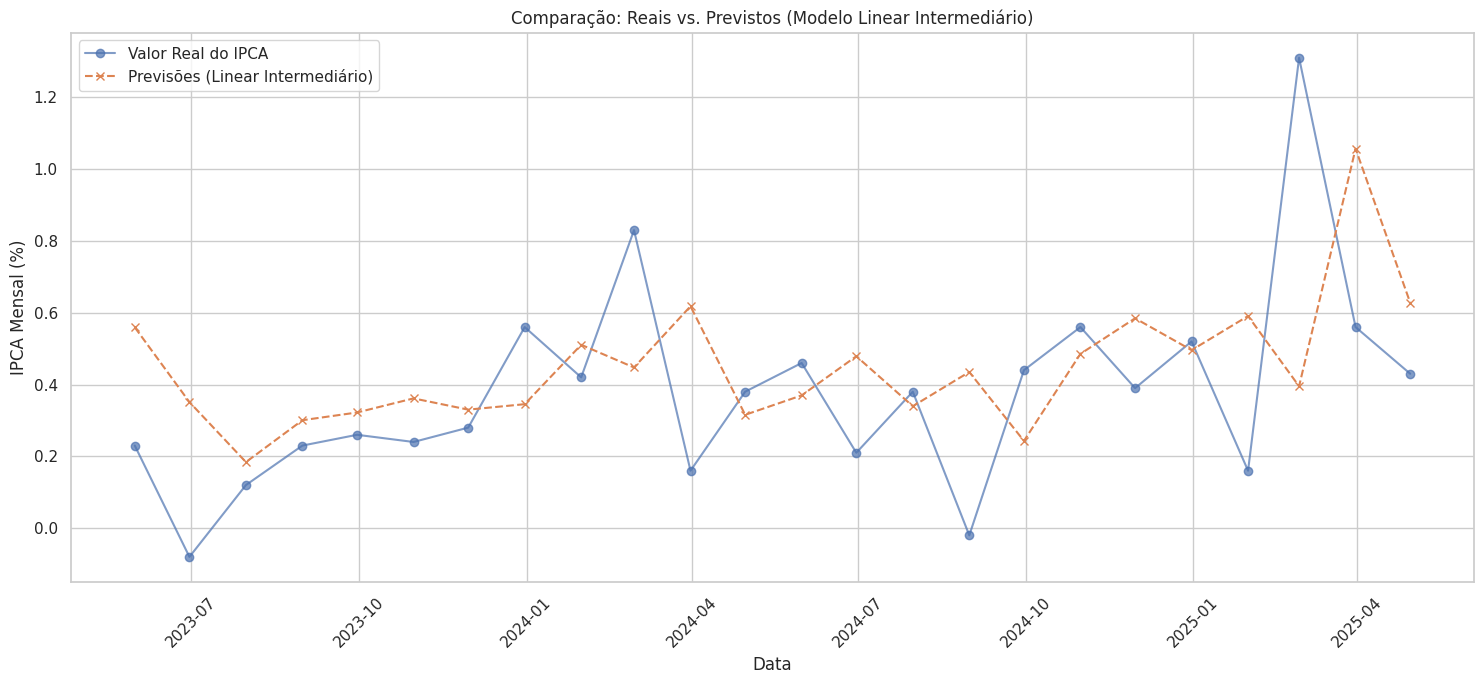

In [25]:
# Gráfico Comparativo (Reais vs. Previstos - Modelo Intermediário)
plt.figure(figsize=(15, 7))
plt.plot(y_int_teste.index, y_int_teste.values, label='Valor Real do IPCA', marker='o', alpha=0.7)
plt.plot(y_int_teste.index, previsoes_linear_int, label='Previsões (Linear Intermediário)', marker='x', linestyle='--')
plt.title('Comparação: Reais vs. Previstos (Modelo Linear Intermediário)')
plt.xlabel('Data')
plt.ylabel('IPCA Mensal (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualização: Reais vs. Previstos (Modelo Linear Intermediário)

O gráfico acima compara visualmente os valores reais do IPCA (linha azul com marcadores 'o') com as previsões geradas pelo modelo linear intermediário (linha vermelha tracejada com marcadores 'x') para o conjunto de teste (os últimos 24 meses, de aproximadamente maio de 2023 a abril de 2025).

*Observações:*
* **Acompanhamento da Tendência:** O modelo intermediário parece acompanhar a direção geral das flutuações do IPCA real em vários momentos. Por exemplo, ele captura a tendência de queda da inflação no segundo semestre de 2023 e a leve aceleração no início de 2024.
* **Magnitude dos Erros:** Visualmente, a linha de previsão (vermelha) está razoavelmente próxima da linha real (azul) na maior parte do tempo. No entanto, ainda existem alguns pontos onde o desvio é mais notável:
    * Por exemplo, em [observar no gráfico um mês específico onde o erro é visível, ex: "meados de 2024"], o modelo parece ter [subestimado/superestimado] a inflação.
    * Em momentos de mudanças mais bruscas ou picos/vales mais acentuados no IPCA real, o modelo linear tende a "suavizar" a previsão, não atingindo as mesmas magnitudes. Isso é uma característica comum de modelos lineares.
* **Comparativo com o Modelo Básico (Qualitativo):** Embora seja uma análise visual, a impressão é que as previsões do modelo intermediário podem estar um pouco mais ajustadas aos valores reais do que as do modelo básico (que usava apenas lags do IPCA). A redução no MAE e RMSE que vimos anteriormente (0.2385 e 0.3175, respectivamente) suporta essa percepção de uma pequena melhora geral.
* **Limitações Persistentes:** Apesar da melhora, o modelo ainda não prevê com perfeição (o que é esperado). A inflação é um fenômeno complexo, e um modelo linear, mesmo com features adicionais, terá dificuldade em capturar todas as nuances e choques inesperados.

*(**Sua tarefa:** Adicione ou ajuste as observações acima com base na sua própria interpretação do gráfico. Seja específico sobre os meses ou períodos que te chamam mais atenção, onde o modelo parece melhor ou pior.)*

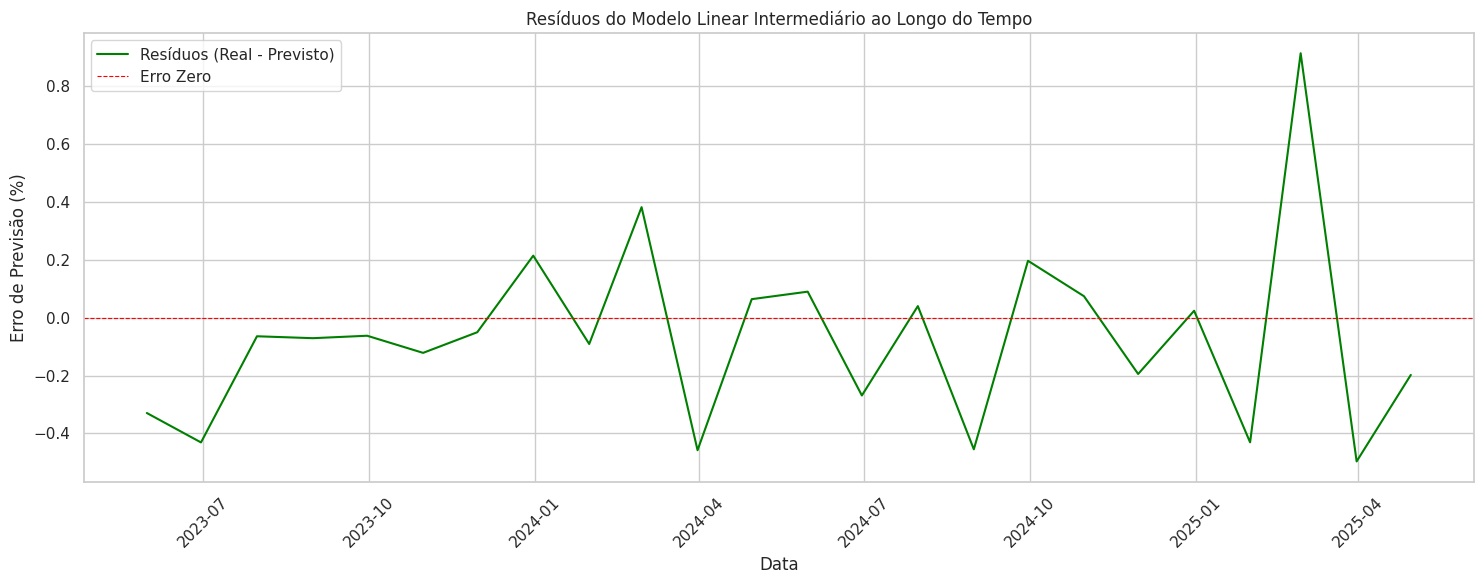

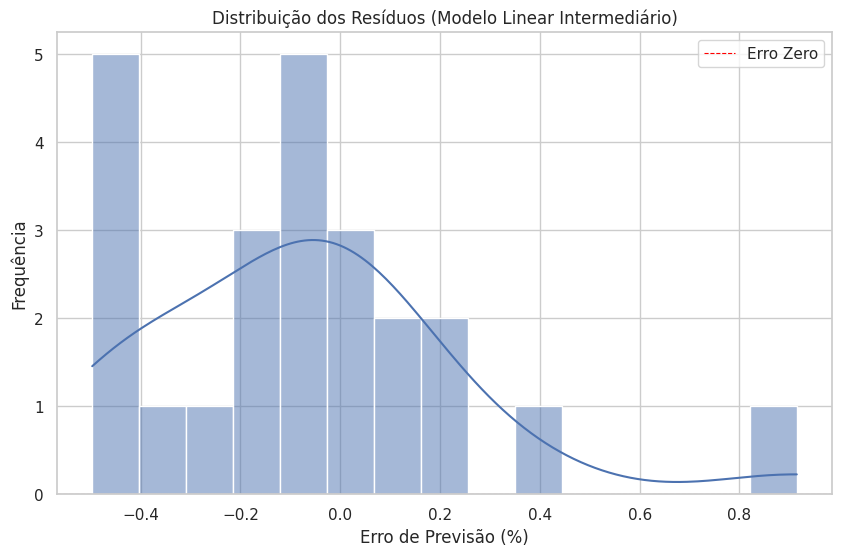

In [26]:
# Análise de Resíduos (Modelo Intermediário)
residuos_linear_int = y_int_teste.values - previsoes_linear_int

plt.figure(figsize=(15, 6))
plt.plot(y_int_teste.index, residuos_linear_int, label='Resíduos (Real - Previsto)', color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.title('Resíduos do Modelo Linear Intermediário ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Erro de Previsão (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuos_linear_int, kde=True, bins=15)
plt.title('Distribuição dos Resíduos (Modelo Linear Intermediário)')
plt.xlabel('Erro de Previsão (%)')
plt.ylabel('Frequência')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.legend()
plt.show()

### Análise dos Resíduos (Modelo Intermediário)

Os gráficos acima mostram os resíduos (diferença entre os valores reais e os previstos) do modelo linear intermediário ao longo do tempo e sua distribuição de frequência.

*Observações:*

* **Resíduos ao Longo do Tempo:**
    * Os erros de previsão parecem flutuar em torno de zero, sem uma tendência clara ou padrão cíclico óbvio. Isso é um bom indicativo, pois sugere que o modelo não está cometendo erros sistemáticos que poderiam ser capturados por uma estrutura temporal não modelada.
    * Existem alguns resíduos de maior magnitude (erros maiores) em certos meses, tanto positivos (modelo subestimou a inflação) quanto negativos (modelo superestimou), mas eles parecem distribuídos de forma relativamente aleatória ao longo do período de teste.

* **Histograma dos Resíduos:**
    * A distribuição dos resíduos está visualmente centrada próxima de zero, o que é desejável.
    * A forma da distribuição se assemelha a uma distribuição normal (forma de sino), embora possa haver uma leve [Ex: assimetria para a direita/esquerda, ou caudas um pouco mais pesadas que uma normal perfeita, dependendo da sua percepção do gráfico]. Uma distribuição de resíduos aproximadamente normal e centrada em zero é uma das premissas de modelos de regressão linear e indica que os erros são aleatórios.
    * A maior parte dos erros de previsão está concentrada em valores pequenos, próximos de zero.

*No geral, a análise dos resíduos do modelo intermediário não levanta grandes alertas. A ausência de padrões fortes nos resíduos é um sinal positivo sobre a adequação do modelo (dentro de suas limitações lineares).*

